In [1]:
from typing import List, Dict, Any
import math
import random

In [2]:
flex = 3

In [3]:
class OperationMode:
    """
    代表一個操作在單一機器上的執行方式 (一個模式)。
    它是處理時間和機器ID的來源，支持機器的不同處理時間。
    """

    def __init__(self, machine_id: int, processing_time: int):
        self.machine_id: int = machine_id  # 機器 ID
        self.processing_time: int = processing_time  # 該模式下的處理時間

    def __str__(self):
        return f"(m={self.machine_id}, t={self.processing_time})"


class Operation:
    """代表一個工作中的單一加工步驟。
    包含該操作的所有可行模式清單，這是彈性的核心。"""

    def __init__(self, op_id: int, job_id: int, pos_in_job: int, modes: list[OperationMode]):
        self.op_id: int = op_id  # 全局唯一 ID
        self.job_id: int = job_id  # 所屬工作 ID
        self.pos_in_job: int = pos_in_job  # 在工作中的順序位置 (1-based)
        self.modes: list[OperationMode] = modes  # 可行模式清單 (List[OperationMode])

    def __str__(self):
        modes_str = ", ".join(str(m) for m in self.modes)
        return (
            f"Operation(op_id={self.op_id}, job_id={self.job_id}, pos_in_job={self.pos_in_job}, "
            f"modes=[{modes_str}])"
        )


class Job:
    """代表一個工作，包含其所有操作的有序序列。"""

    def __init__(self, job_id: int, operations: list[Operation]):
        self.job_id: int = job_id  # 工作 ID
        self.operations: list[Operation] = operations  # 有序的操作清單

    def __str__(self):
        # Only print crucial information: op_id, pos_in_job, and modes count
        ops_str = ", ".join("(" + ", ".join(str(mode) for mode in op.modes) + ")" for op in self.operations)
        return f"Job(j_id={self.job_id}, op_cnt == {len(self.operations)}, ops == [{ops_str}])"

In [4]:
def format_tai_to_fjssp(file_content: str) -> Dict[str, Any]:
    """
    Parses content in Tai's JSSP format and converts it into an abstract FJSSP Job structure.

    Each line represents a job:
    - The first line contains two integers: job_cnt and machine_cnt.
    - Each subsequent line (one per job) contains pairs of numbers: (machine_id, processing_time) in order, representing all possible (machine, time) combinations for each operation.

    Args:
        file_content: str - The complete textual content of an FJSSP file.

    Returns:
        A dictionary containing:
            - 'jobs': List[Job] - the list of Job objects
            - 'machine_cnt': int - the number of machines
            - 'operations': List[Operation] - all operations across all jobs
    """

    # 分行
    lines = [line.strip() for line in file_content.strip().split("\n") if line.strip()]
    if len(lines) < 1:
        raise ValueError("內容缺少參數行")

    # 第一行：取出 job_cnt 與 machine_cnt
    top_tokens = lines[0].split()
    if len(top_tokens) < 2:
        raise ValueError("首行缺少 job_cnt 與 machine_cnt 參數")
    job_cnt = int(top_tokens[0])
    machine_cnt = int(top_tokens[1])

    # 從第二行開始，逐行處理每個工作
    all_jobs_data = []
    current_op_id = 0

    for job_idx, line in enumerate(lines[1:]):
        tokens = line.strip().split()
        if len(tokens) < 1:
            continue
        job_operations = []

        for i in range(0, len(tokens), 2):
            pos = i // 2 + 1
            machine_id = int(tokens[i])
            processing_time = int(tokens[i + 1])

            mode = OperationMode(machine_id=machine_id, processing_time=processing_time)

            operation = Operation(op_id=current_op_id, job_id=job_idx, pos_in_job=pos, modes=[mode])
            job_operations.append(operation)
            current_op_id += 1

        all_jobs_data.append(Job(job_id=job_idx, operations=job_operations))

    # Compute the union of all jobs' operations
    all_operations = []
    for job in all_jobs_data:
        all_operations.extend(job.operations)

    return {
        "jobs": all_jobs_data,
        "machine_cnt": machine_cnt,
        "operations": all_operations,
    }

In [5]:
def format_fjssp_to_brd(jobs: List[Job], machine_cnt: int) -> str:
    """
    Convert abstract FJSSP jobs to BRD format.

    Args:
        jobs: List[Job], List of Job objects
        machine_cnt: int, total machine count

    Returns:
        str, BRD format string
    """

    job_cnt = len(jobs)
    machine_cnt = machine_cnt

    brd_str = f"{job_cnt} {machine_cnt} {flex}\n"
    for job in jobs:
        job_line_str = f"{len(job.operations)} "
        for op in job.operations:
            job_line_str += f"{len(op.modes)} "
            for mode in op.modes:
                job_line_str += f"{mode.machine_id} {mode.processing_time} "
        brd_str += job_line_str + "\n"
    return brd_str

In [6]:
def process_parallel(data: Dict[str, Any], flex: int) -> Dict[str, Any]:
    """
    For each machine_id, collect its operations, create (flex-1) new machines,
    and for each operation, add the new machines (with the same processing time) to its modes list.

    Args:
        data: Dictionary containing 'jobs', 'machine_cnt', etc.
        flex: The degree of parallelism (number of parallel machines per original machine).
    Returns:
        jobs: List[Job], List of jobs with modified operations
        machine_cnt: int, new total machine count
    """
    
    jobs = data["jobs"]
    M_orig = data["machine_cnt"]
    next_machine_id = M_orig  # Start assigning new IDs after the originals

    for machine_id in range(M_orig):
        new_machine_ids = [next_machine_id + i for i in range(flex - 1)]
        next_machine_id += flex - 1
        # For each op whose first mode's machine_id equals machine_id, append new modes for the new machines
        for op in [op for op in data["operations"] if op.modes[0].machine_id == machine_id]:
            orig_time = op.modes[0].processing_time
            # Append new modes for each new machine (flex-1 replicas)
            for new_machine_id in new_machine_ids:
                new_mode = OperationMode(machine_id=new_machine_id, processing_time=orig_time)
                op.modes.append(new_mode)

    return {
        "jobs": jobs,
        "machine_cnt": next_machine_id,
    }

In [7]:
def process_closed(data: Dict[str, Any], flex: int) -> None:
    """
    將 JSSP 的 instance 轉換成 closed FJSSP 的 instance
    會直接更改 data 的內容

    Param:
        data: Dict[str, Any] - 原始的 JSSP 的 instance
            - 'jobs': List[Job] - 工作列表
            - 'machine_cnt': int - 機器數量
            - 'operations': List[Operation] - 所有操作
        flex: int - 彈性度
    Returns:
        None
    """

    # Partitioning 
    machine_cnt = data.get("machine_cnt", 0)
    set_size = flex
    set_cnt = math.ceil(machine_cnt / flex)
    machines = list(range(set_cnt * set_size))
    data["machine_cnt"] = set_cnt * set_size
    random.shuffle(machines)
    machine_sets = [set(machines[i : i + set_size]) for i in range(0, len(machines), set_size)]

    new_machine_set_dict: Dict[int, set[int]] = {}
    for s in machine_sets:
        for m in s:
            new_machine_set_dict[m] = s.copy()

    for operation in data["operations"]:
        processing_time = operation.modes[0].processing_time
        cur_machine = operation.modes[0].machine_id

        for m in new_machine_set_dict[cur_machine]:
            if m == cur_machine:
                continue
            new_mode = OperationMode(machine_id=m, processing_time=processing_time)
            operation.modes.append(new_mode)

In [8]:
from platform import machine


def process_linked(data: Dict[str, Any], flex: int) -> None:
    """
    將 JSSP 的 instance 轉換成 linked FJSSP 的 instance

    Param:
        data: Dict[str, Any] - 原始的 JSSP 的 instance
            - 'jobs': List[Job] - 工作列表
            - 'machine_cnt': int - 機器數量
            - 'operations': List[Operation] - 所有操作
        flex: int - 彈性度
    Returns:
        None
    """

    machine_cnt = data["machine_cnt"]
    for op in data["operations"]:
        cur_machine = op.modes[0].machine_id
        processing_time = op.modes[0].processing_time
        new_machines = [(cur_machine + i) % machine_cnt for i in range(flex)]
        for m in new_machines:
            if m == cur_machine:
                continue
            new_mode = OperationMode(machine_id=m, processing_time=processing_time)
            op.modes.append(new_mode)

In [9]:
with open("./tai_j10_m10_1.data", "r") as f:
    content = f.read()
    data = format_tai_to_fjssp(content)

In [10]:
result = process_linked(data, flex)

Clusters of machines (machines are clustered if they share at least one operation):
Cluster 1: ['M0', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


C:\Users\PuSung\AppData\Local\Temp\ipykernel_44308\1783331936.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(machine_clusters))


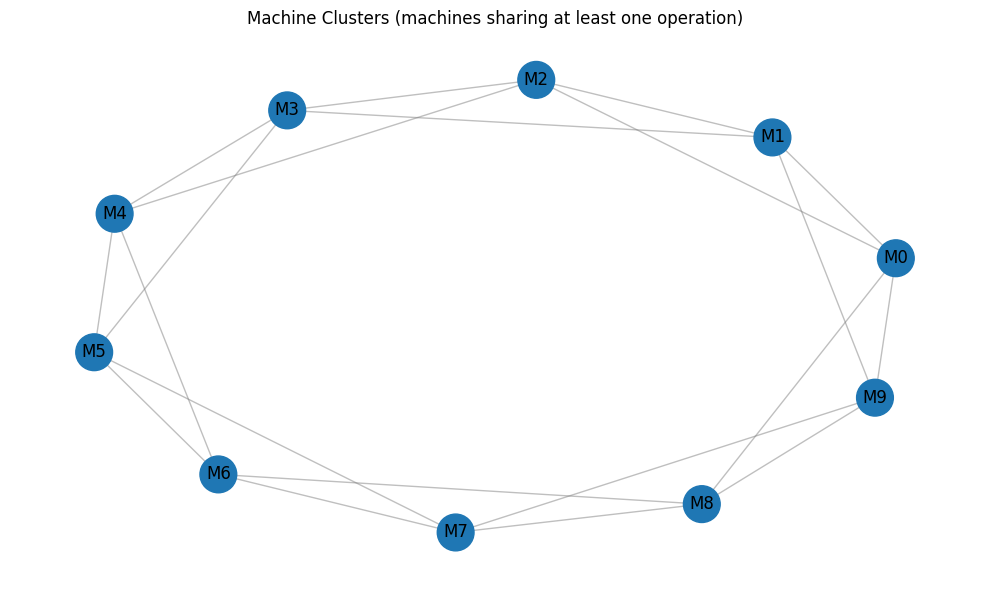

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a machine graph:
# Two machines are connected if they both can process the same operation.

machine_cnt = data["machine_cnt"]
machine_nodes = [f"M{m}" for m in range(machine_cnt)]

# For each operation, get its feasible machines
operation_to_machines = []
for operation in data["operations"]:
    machines = set(f"M{mode.machine_id}" for mode in operation.modes)
    operation_to_machines.append(machines)

# Build the machine similarity graph
MG = nx.Graph()
MG.add_nodes_from(machine_nodes)

for machines in operation_to_machines:
    machines = list(machines)
    # For each pair of machines that can process the same operation, connect them
    for i in range(len(machines)):
        for j in range(i + 1, len(machines)):
            MG.add_edge(machines[i], machines[j])

# Now, clusters are connected components of MG
machine_clusters = list(nx.connected_components(MG))
print("Clusters of machines (machines are clustered if they share at least one operation):")
for idx, cluster in enumerate(machine_clusters):
    print(f"Cluster {idx + 1}: {sorted(cluster)}")

# Visualization (layout as a machine graph, cluster coloring)
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(MG, seed=42)
colors = plt.cm.get_cmap('tab10', len(machine_clusters))
node_colors = {}
for idx, cluster in enumerate(machine_clusters):
    for m in cluster:
        node_colors[m] = colors(idx)

for idx, cluster in enumerate(machine_clusters):
    nx.draw_networkx_nodes(
        MG, pos,
        nodelist=list(cluster),
        node_color=[colors(idx)] * len(cluster),
        node_size=700,
        alpha=1.0,
        label=f"Cluster {idx+1}"
    )

nx.draw_networkx_edges(MG, pos, edge_color='grey', alpha=0.5)
nx.draw_networkx_labels(MG, pos, font_size=12)

plt.title("Machine Clusters (machines sharing at least one operation)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
for op in data["jobs"][0].operations:
    print(op)

Operation(op_id=0, job_id=0, pos_in_job=1, modes=[(m=6, t=324), (m=7, t=324), (m=8, t=324)])
Operation(op_id=1, job_id=0, pos_in_job=2, modes=[(m=3, t=70), (m=4, t=70), (m=5, t=70)])
Operation(op_id=2, job_id=0, pos_in_job=3, modes=[(m=2, t=639), (m=3, t=639), (m=4, t=639)])
Operation(op_id=3, job_id=0, pos_in_job=4, modes=[(m=1, t=866), (m=2, t=866), (m=3, t=866)])
Operation(op_id=4, job_id=0, pos_in_job=5, modes=[(m=7, t=109), (m=8, t=109), (m=9, t=109)])
Operation(op_id=5, job_id=0, pos_in_job=6, modes=[(m=8, t=692), (m=9, t=692), (m=0, t=692)])
Operation(op_id=6, job_id=0, pos_in_job=7, modes=[(m=4, t=14), (m=5, t=14), (m=6, t=14)])
Operation(op_id=7, job_id=0, pos_in_job=8, modes=[(m=9, t=43), (m=0, t=43), (m=1, t=43)])
Operation(op_id=8, job_id=0, pos_in_job=9, modes=[(m=0, t=170), (m=1, t=170), (m=2, t=170)])
Operation(op_id=9, job_id=0, pos_in_job=10, modes=[(m=5, t=930), (m=6, t=930), (m=7, t=930)])


In [13]:
# 執行彈性模式添加
fjs_data_parallel = process_parallel(data, flex)

In [14]:
brd_str = format_fjssp_to_brd(fjs_data_parallel["jobs"], fjs_data_parallel["machine_cnt"])